In [ ]:
#!pip install googletrans==4.0.0rc1

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json

from googletrans import Translator

import networkx as nx
import seaborn as sns

import mlxtend.frequent_patterns 
import mlxtend.preprocessing

In [156]:
df = pd.read_csv("datasets/Groceries_dataset.csv")

with open("config/github_access.json") as f:
  acces_to_github = json.load(f)

In [ ]:
df.shape

(38765, 3)

In [ ]:
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [210]:
class Processingdata:

  def __init__(self,df):
    self.df_original = df
    self.translator = Translator()
  
  def transform_columns(self,df):
    
    # str to column
    df["Date"] = pd.to_datetime(df["Date"]) 
    df["yyyymm"] = df["Date"].apply(lambda x: datetime.strftime(x,"%Y-%m-01"))
    df["yyyymm"] = pd.to_datetime(df["yyyymm"]) 
    return df
  
  def translate_column(self,df,translator):
    
    dic_f = dict()
    lista_items = df["itemDescription"].unique().tolist()
    for item in lista_items:
      try:
        trans = translator.translate(item, src="en", dest='es').text
      except:
        trans = item  
        print(f"error en {item}")
      dic_f[item] = trans

    dic_f["pork"] = "cerdo"
    dic_f["turkey"] = "pavo"
    dic_f["cleaner"] = "limpiador"

    return dic_f

  def process(self):
    
    df_t = self.transform_columns(self.df_original)
    dic_f = self.translate_column(df_t,self.translator)
    df_clean = df_t.replace({"itemDescription":dic_f})
    self.df_clean = df_clean
    

In [211]:
clean = Processingdata(df)
clean.process()

error en pork
error en turkey
error en cleaner


In [212]:
clean.df_clean

,Member_number,Date,itemDescription,yyyymm
0,1808,2015-07-21,fruta tropical,2015-07-01
1,2552,2015-05-01,leche entera,2015-05-01
2,2300,2015-09-19,fruta,2015-09-01
3,1187,2015-12-12,Otras verduras,2015-12-01
4,3037,2015-01-02,leche entera,2015-01-01
...,...,...,...,...
38760,4471,2014-08-10,queso en rodajas,2014-08-01
38761,2022,2014-02-23,caramelo,2014-02-01
38762,1097,2014-04-16,barra de pastel,2014-04-01
38763,1510,2014-03-12,jugo de fruta/vegetal,2014-03-01


Top de productos por consumo

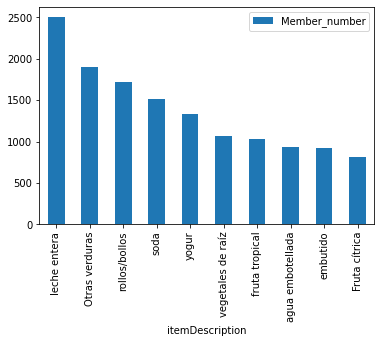

In [186]:
clean.df_clean.groupby("itemDescription").count()["Member_number"].reset_index().sort_values("Member_number",ascending=False).reset_index(drop=True).iloc[:10,:].plot.bar(x="itemDescription")

Top de Productos Menos comprados

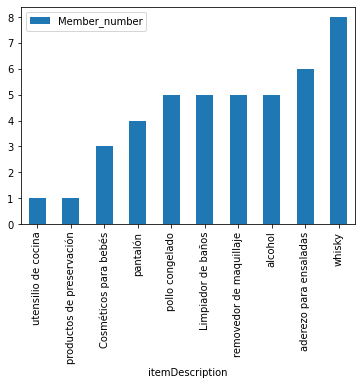

In [187]:
clean.df_clean.groupby("itemDescription").count()["Member_number"].reset_index().sort_values("Member_number").reset_index(drop=True).iloc[:10,:].plot.bar(x="itemDescription")

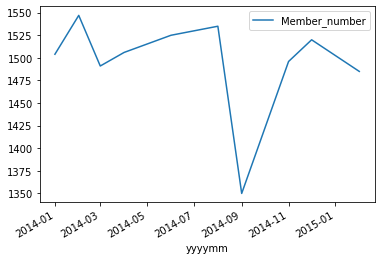

In [214]:
clean.df_clean.groupby("yyyymm").count()["Member_number"].reset_index().sort_values("Member_number").reset_index(drop=True).iloc[:10,:].plot(x="yyyymm")

In [263]:
top_5_by_year = clean.df_clean.groupby(["yyyymm","itemDescription"]).count()["Member_number"].reset_index().sort_values(["yyyymm","Member_number"],ascending=False)
top_5_by_year = top_5_by_year.groupby("yyyymm").head(5)

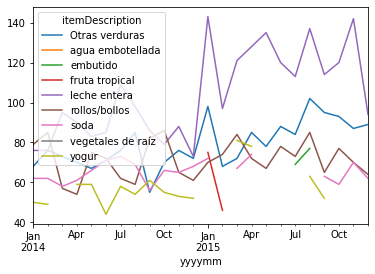

In [264]:
top_5_by_year.pivot(index="yyyymm",columns="itemDescription",values="Member_number").plot()

Análisis de Matriz de transacciones y productos

In [399]:
sum = clean.df_clean.groupby(["Member_number","Date","itemDescription"]).count()["yyyymm"]
sum = sum.unstack("itemDescription").reset_index()
sum.drop("Date",inplace=True,axis=1)
sum = sum.groupby("Member_number").count().reset_index()
sum[(sum>0) & (sum<999)] = 1
sum

itemDescription,Member_number,Cosméticos para bebés,Cuajada,Fruta cítrica,Levadura en polvo,Limpiador de baños,Otras verduras,Palomitas,Pastelería,Película/bolsas portar,...,vegetales de raíz,vegetales en escabeche,vegetales especiales,velas,vinagre,vino blanco,vino espumoso,vino rojo/rubor,whisky,yogur
0,1000,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,1001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1002,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1003,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1004,0,0,0,0,0,1,0,1,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3893,4996,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3894,4997,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3895,4998,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3896,4999,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [442]:
class metricas_asociacion:

  def __init__(self,df):
    self.df = df

  def soporte(self,productos):
    
    if len(productos)==1:
      subset = self.df.loc[self.df[productos[0]]>0]
    else:
      df = self.df.copy()
      df["coocurrencia"] = df[productos].sum(axis=1)
      subset = df.loc[df["coocurrencia"]>(len(productos)-1)]

    return subset.shape[0]/self.df.shape[0]

  def confianza(self,productos):
    if len(productos)==1:
      print("Debe ingresar por lo menos dos productos")
    else:
      soporte_x_y = self.soporte(productos)
      soporte_x = self.soporte([productos[0]])
      return soporte_x_y/soporte_x

  def lift(self,productos):
    if len(productos)==1:
      print("Debe ingresar por lo menos dos productos")
    
    else:
      soporte_x_y = self.soporte(productos)
      soportes = np.array([self.soporte([item]) for item in productos])
      return soporte_x_y/(soportes.prod())


In [350]:
sum.columns

Index(['Member_number', 'Cosméticos para bebés', 'Cuajada', 'Fruta cítrica',
       'Levadura en polvo', 'Limpiador de baños', 'Otras verduras',
       'Palomitas', 'Pastelería', 'Película/bolsas portar',
       ...
       'vegetales de raíz', 'vegetales en escabeche', 'vegetales especiales',
       'velas', 'vinagre', 'vino blanco', 'vino espumoso', 'vino rojo/rubor',
       'whisky', 'yogur'],
      dtype='object', name='itemDescription', length=168)

In [373]:
a = ["leche entera","rollos/bollos","Otras verduras"]

'leche entera->rollos/bollos,Otras verduras'

In [458]:
metricas = metricas_asociacion(sum)
metricas.soporte(["leche entera","vino rojo/rubor"])

0.021549512570549

In [422]:
metricas.soporte(["leche entera","Cosméticos para bebés"])

0.0

In [446]:
metricas.confianza(["leche entera","yogur","rollos/bollos"])

0.1438969764837626

In [452]:
metricas.lift(["leche entera","vino rojo/rubor"])

1.1827908824910596

In [441]:
metricas.lift(["leche entera","yogur"])

1.1615100423460805

In [352]:
metricas.df.columns

Index(['Member_number', 'Cosméticos para bebés', 'Cuajada', 'Fruta cítrica',
       'Levadura en polvo', 'Limpiador de baños', 'Otras verduras',
       'Palomitas', 'Pastelería', 'Película/bolsas portar',
       ...
       'vegetales de raíz', 'vegetales en escabeche', 'vegetales especiales',
       'velas', 'vinagre', 'vino blanco', 'vino espumoso', 'vino rojo/rubor',
       'whisky', 'yogur'],
      dtype='object', name='itemDescription', length=168)

In [473]:
a = sum[["leche entera","vino rojo/rubor"]].sort_values(["leche entera","vino rojo/rubor"],ascending=False).sum(axis=1)>1
c = a.sum()/a.shape[0]
c/(metricas.soporte(["vino rojo/rubor"])*metricas.soporte(["leche entera"]))

0.021549512570549

In [347]:
sum.columns

Index(['Member_number', 'Cosméticos para bebés', 'Cuajada', 'Fruta cítrica',
       'Levadura en polvo', 'Limpiador de baños', 'Otras verduras',
       'Palomitas', 'Pastelería', 'Película/bolsas portar',
       ...
       'vegetales especiales', 'velas', 'vinagre', 'vino blanco',
       'vino espumoso', 'vino rojo/rubor', 'whisky', 'yogur', 'coocurencia',
       'coocurrencia'],
      dtype='object', name='itemDescription', length=170)

In [487]:
encode_df = sum.copy()
encode_df.set_index("Member_number",drop=True,inplace=True)
encode_df = encode_df.astype(bool)
encode_df
md=mlxtend.frequent_patterns.apriori(encode_df)
md_minsup=mlxtend.frequent_patterns.apriori(encode_df,
                                           min_support=0.01, 
                                            use_colnames=True)

In [488]:
md_minsup.head(20)

,support,itemsets
0,0.120831,(Cuajada)
1,0.185480,(Fruta cítrica)
2,0.031042,(Levadura en polvo)
3,0.376603,(Otras verduras)
4,0.012057,(Palomitas)
5,0.177527,(Pastelería)
6,0.018728,(Película/bolsas portar)
7,0.025911,(Pez congelado)
8,0.023089,(Postre congelado)
9,0.065418,(Producto de panadería Long Life)


In [489]:
rules=mlxtend.frequent_patterns.association_rules(md_minsup, metric="confidence",min_threshold=0.06,support_only=False)
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Fruta cítrica),(Cuajada),0.185480,0.120831,0.025654,0.138313,1.144676,0.003242,1.020287
1,(Cuajada),(Fruta cítrica),0.120831,0.185480,0.025654,0.212314,1.144676,0.003242,1.034068
2,(Otras verduras),(Cuajada),0.376603,0.120831,0.051565,0.136921,1.133159,0.006059,1.018642
3,(Cuajada),(Otras verduras),0.120831,0.376603,0.051565,0.426752,1.133159,0.006059,1.087481
4,(Pastelería),(Cuajada),0.177527,0.120831,0.027193,0.153179,1.267712,0.005743,1.038199
5,(Cuajada),(Pastelería),0.120831,0.177527,0.027193,0.225053,1.267712,0.005743,1.061328
6,(Uht-leche),(Cuajada),0.078502,0.120831,0.013597,0.173203,1.433426,0.004111,1.063343
7,(Cuajada),(Uht-leche),0.120831,0.078502,0.013597,0.112527,1.433426,0.004111,1.038339
8,(agua embotellada),(Cuajada),0.213699,0.120831,0.033094,0.154862,1.281639,0.007272,1.040266
9,(Cuajada),(agua embotellada),0.120831,0.213699,0.033094,0.273885,1.281639,0.007272,1.082888


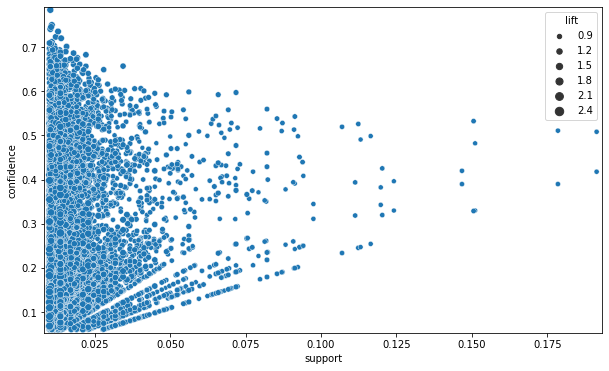

In [490]:
# Generate scatterplot using support and confidence
plt.figure(figsize=(10,6))
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.margins(0.01,0.01)
plt.show()

In [491]:
rules2=mlxtend.frequent_patterns.association_rules(md_minsup, metric="lift",min_threshold=0.06,support_only=False)

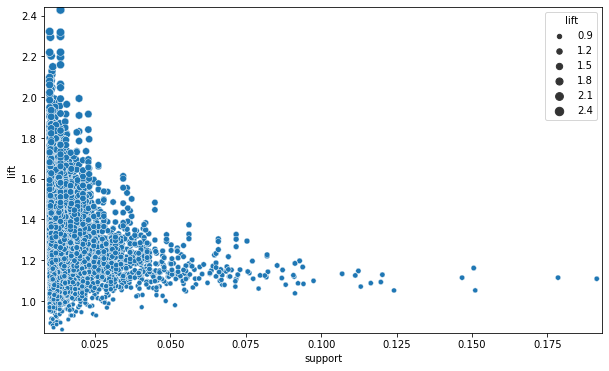

In [493]:
import networkx as nx
import seaborn as sns

# Generate scatterplot using support and confidence
plt.figure(figsize=(10,6))
sns.scatterplot(x = "support", y = "lift", 
                size = "lift", data = rules2)
plt.margins(0.01,0.01)
plt.show()

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   MarketBasket.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
